In [ ]:
!pip install -q gigachat
!pip install -q langchain-gigachat

# start
В этом ноуте по таблице с колонками question, golden_answer, rag_answer считаются метрики:

1. BLEU . Считается для колонок golden_answer и rag_answer
2. Rouge для 1-gramm, 2-gramm, rouge_l_summary_level. Считается для колонок golden_answer и rag_answer
3. Дать LLM все 3 колонки и попросить оценить качество ответа
 

Материалы
- https://www.elastic.co/search-labs/blog/evaluating-rag-metrics
- gigachain https://developers.sber.ru/docs/ru/gigachain/tutorials/chatbot

In [1]:
import pandas as pd

df = pd.read_csv('../dataset_qa_all_gpt4o_answ.csv', sep='@')
columns = {
    'question': 'Вопрос',
    'golden_answer': 'Ответ',
    'rag_answer': 'gpt4o'
}

df = pd.DataFrame(data={col : df[col_old] for col, col_old in columns.items()})
df.head()  # we work on evaluation of data in such format

,question,golden_answer,rag_answer
0,Какие требования предъявляются для перехода на...,"Кредитная организация, соответствующая критери...",Для перехода на применение расчетного КВП необ...
1,Какие действия нужно предпринять в случае реор...,При присоединении другой кредитной организации...,При реорганизации в форме присоединения другой...
2,Какие особенности применения расчетного КВП су...,Системно значимые кредитные организации обязан...,Особенности применения расчетного КВП для сист...
3,Какие методики и процедуры расчета оп риска до...,Организация должна зафиксировать во внутренних...,Методики и процедуры расчета операционного рис...
4,Какие требования должны быть выполнены для иск...,Кредитная организация может исключить определе...,Для исключения доходов и расходов из расчета к...


# BLEU

In [ ]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def compute_bleu(reference, hypothesis):
    return sentence_bleu([reference.split()], hypothesis.split(), smoothing_function=SmoothingFunction().method1)


df['bleu'] = df.apply(lambda x: compute_bleu(x['golden_answer'], x['rag_answer']), axis=1)

df.head()

,question,golden_answer,rag_answer,bleu
0,Какие требования предъявляются для перехода на...,"Кредитная организация, соответствующая критери...",Для перехода на применение расчетного КВП необ...,0.014105
1,Какие действия нужно предпринять в случае реор...,При присоединении другой кредитной организации...,При реорганизации в форме присоединения другой...,0.018000
2,Какие особенности применения расчетного КВП су...,Системно значимые кредитные организации обязан...,Особенности применения расчетного КВП для сист...,0.009707
3,Какие методики и процедуры расчета оп риска до...,Организация должна зафиксировать во внутренних...,Методики и процедуры расчета операционного рис...,0.078697
4,Какие требования должны быть выполнены для иск...,Кредитная организация может исключить определе...,Для исключения доходов и расходов из расчета к...,0.009645


# Rouge
I think we should look only on f1 scores, probably chose 1 of 3

about rouge-l:

    Computes ROUGE-L (summary level) of two text collections of sentences.
    http://research.microsoft.com/en-us/um/people/cyl/download/papers/rouge-working-note-v1.3.1.pdf

    Calculated according to:
    R_lcs = SUM(1, u)[LCS<union>(r_i,C)]/m
    P_lcs = SUM(1, u)[LCS<union>(r_i,C)]/n
    F_lcs = (2*R_lcs*P_lcs) / (R_lcs * P_lcs)

    where:
    SUM(i,u) = SUM from i through u
    u = number of sentences in reference summary
    C = Candidate summary made up of v sentences
    m = number of words in reference summary
    n = number of words in candidate summary


In [51]:
from rouge import Rouge

rouge = Rouge()
def compute_rouge(reference, hypothesis):
    '''
    ROUGE-1: Measures the overlap of unigrams (individual words) between the generated text and the reference text.
    ROUGE-2: Measures the overlap of bigrams 
    ROUGE-L: Measures the longest common subsequence (LCS) between the generated and reference text. 
        It reflects the sequence similarity and accounts for in-order matches.
    r, p, f: recall, precision, and F1-score, respectively.
    '''
    return rouge.get_scores(hypothesis, reference)[0]

df['rouge'] = df.apply(lambda x: compute_rouge(x['golden_answer'], x['rag_answer']), axis=1)
rouge_format = {'rouge-1': {'r': 0., 'p': 0., 'f': 0.},
                'rouge-2': {'r': 0., 'p': 0., 'f': 0.},
                'rouge-l': {'r': 0., 'p': 0., 'f': 0.}}
for k1 in rouge_format:
    for k2 in rouge_format[k1]:
        df[k1 + '_' + k2] = df.apply(lambda x: x['rouge'][k1][k2], axis=1)

df.drop(columns=['rouge'], inplace=True)

df.head()

,question,golden_answer,rag_answer,bleu,llm_score1,llm_score1_desc,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f
0,Какие требования предъявляются для перехода на...,"Кредитная организация, соответствующая критери...",Для перехода на применение расчетного КВП необ...,0.014105,7,The model answer is somewhat relevant but lack...,0.169014,0.387097,0.235294,0.086420,0.205882,0.121739,0.154930,0.354839,0.215686
1,Какие действия нужно предпринять в случае реор...,При присоединении другой кредитной организации...,При реорганизации в форме присоединения другой...,0.018000,7,The model answer provides a general instructio...,0.175439,0.322581,0.227273,0.048387,0.093750,0.063830,0.175439,0.322581,0.227273
2,Какие особенности применения расчетного КВП су...,Системно значимые кредитные организации обязан...,Особенности применения расчетного КВП для сист...,0.009707,6,The model answer is partially relevant and lac...,0.125000,0.166667,0.142857,0.019231,0.026316,0.022222,0.125000,0.166667,0.142857
3,Какие методики и процедуры расчета оп риска до...,Организация должна зафиксировать во внутренних...,Методики и процедуры расчета операционного рис...,0.078697,6,The model answer is partially relevant and som...,0.194444,0.233333,0.212121,0.095238,0.121212,0.106667,0.166667,0.200000,0.181818
4,Какие требования должны быть выполнены для иск...,Кредитная организация может исключить определе...,Для исключения доходов и расходов из расчета к...,0.009645,7,The model answer provides a general idea about...,0.254545,0.437500,0.321839,0.016667,0.031250,0.021739,0.200000,0.343750,0.252874


# LLM metrics (via Gigachat api)

In [ ]:
from gigachat import GigaChat
import requests
from tokens import GIGACHAT_AUTHORIZATION_KEY

# GIGACHAT_AUTHORIZATION_KEY = ...
# free tarif plan

url = "https://ngw.devices.sberbank.ru:9443/api/v2/oauth"

payload={
  'scope': 'GIGACHAT_API_PERS'
}
headers = {
  'Content-Type': 'application/x-www-form-urlencoded',
  'Accept': 'application/json',
  'RqUID': '2436021c-6404-4b41-a981-5ed50973c515',
  'Authorization': f'Basic {GIGACHAT_AUTHORIZATION_KEY}'
}

response = requests.request("POST", url, headers=headers, data=payload, verify=False)

print(response)

GIGACHAT_ACCESS_TOKEN = response.json()['access_token']

<Response [200]>


/Users/ark.andreev/venvs/venv_py312/lib/python3.12/site-packages/urllib3/connectionpool.py:1099: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ngw.devices.sberbank.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


In [40]:
from langchain_core.messages import HumanMessage, SystemMessage
from langchain_gigachat.chat_models import GigaChat

# Авторизация в GigaChat
model = GigaChat(
    credentials=GIGACHAT_AUTHORIZATION_KEY,
    scope="GIGACHAT_API_PERS",
    model=["GigaChat", "GigaChat-Pro"][1],
    # Отключает проверку наличия сертификатов НУЦ Минцифры
    verify_ssl_certs=False,
)

# messages = [
#     SystemMessage(
#         content="Ты эмпатичный бот-психолог, который помогает пользователю решить его проблемы."
#     )
# ]

# while(True):
#     user_input = input("Пользователь: ")
#     if user_input == "пока":
#       break
#     messages.append(HumanMessage(content=user_input))
#     res = model.invoke(messages)
#     messages.append(res)
#     print("GigaChat: ", res.content)

model.invoke("What is the capital of Russia?")

AIMessage(content='The capital of Russia is Moscow. It is the largest city in the country and a major cultural, political, and economic center.', additional_kwargs={}, response_metadata={'token_usage': Usage(prompt_tokens=18, completion_tokens=27, total_tokens=45), 'model_name': 'GigaChat-Pro:1.0.26.20', 'finish_reason': 'stop'}, id='run-dc1c3462-e2cf-412e-b25d-369e58384ea4-0')

In [50]:
from ast import literal_eval
from langchain.chat_models.gigachat import GigaChat
from tqdm import tqdm

model = GigaChat(
    credentials=GIGACHAT_AUTHORIZATION_KEY,
    scope="GIGACHAT_API_PERS",
    model=["GigaChat", "GigaChat-Pro"][0],
    # Отключает проверку наличия сертификатов НУЦ Минцифры
    verify_ssl_certs=False,
)

def evaluate_with_llm(question, golden_answer, rag_answer):
    prompt = f"""
    Evaluate the quality of the answer provided by the model for given question, considering golden answer on this question.
    Question: {question}
    Golden Answer: {golden_answer}
    Model Answer: {rag_answer}
    Please provide a score between 1 (very poor) and 10 (excellent) based on relevance, correctness, and completeness.
    Please answer with dict with 2 key values, description - a string explaining score, score - integer value from 1 to 10."""
    response = model.invoke(prompt)
    answer = response.content
    answer = '\n'.join(answer.split('\n')[1:-1])  # answer looks like ```json \n{'description:'...} \n```
    answer = literal_eval(answer)
    return answer

df['llm_score1_desc'] = ''
df['llm_score1'] = ''
for i, row in tqdm(df.iterrows(), total=len(df)):
    model_evaluation = evaluate_with_llm(row['question'], row['golden_answer'], row['rag_answer'])
    # print(model_evaluation)
    df.loc[i, 'llm_score1_desc'] = model_evaluation['description']
    df.loc[i, 'llm_score1'] = model_evaluation['score']

df.head()

  2%|▎         | 1/40 [00:00<00:38,  1.01it/s]

{'description': 'The model answer is somewhat relevant but lacks specificity and completeness compared to the golden answer.', 'score': 7}


  5%|▌         | 2/40 [00:01<00:36,  1.05it/s]

{'description': 'The model answer provides a general instruction to integrate bases events and update data in Bank Russia, which is somewhat relevant but lacks specific details and accuracy compared to the golden answer.', 'score': 7}


  8%|▊         | 3/40 [00:02<00:32,  1.13it/s]

{'description': 'The model answer is partially relevant and lacks specific details about the timeline and regulatory requirements.', 'score': 6}


 10%|█         | 4/40 [00:03<00:30,  1.18it/s]

{'description': 'The model answer is partially relevant and somewhat incomplete compared to the golden answer.', 'score': 6}


 12%|█▎        | 5/40 [00:04<00:30,  1.16it/s]

{'description': 'The model answer provides a general idea about excluding certain income and expenses from KBI calculation but lacks specific details and references to regulatory requirements.', 'score': 7}


 15%|█▌        | 6/40 [00:05<00:28,  1.18it/s]

{'description': 'Model answer is relevant and partially accurate but lacks specificity and detail compared to the golden answer.', 'score': 6}


 18%|█▊        | 7/40 [00:06<00:28,  1.17it/s]

{'description': 'The model answer is largely consistent with the golden answer in terms of measures that Bank Russia can take and their implications on KVP calculation.', 'score': 8}


 20%|██        | 8/40 [00:06<00:26,  1.19it/s]

{'description': 'The model answer provides general guidance but lacks specificity and detail required in the golden answer.', 'score': 6}


 22%|██▎       | 9/40 [00:07<00:26,  1.18it/s]

{'description': 'The model answer provides a very basic explanation but lacks specific details and context required in the golden answer.', 'score': 4}


 25%|██▌       | 10/40 [00:08<00:25,  1.19it/s]

{'description': 'The model answer is partially relevant and somewhat correct but lacks completeness compared to the golden answer.', 'score': 6}


 28%|██▊       | 11/40 [00:09<00:24,  1.19it/s]

{'description': "The model's answer provides a relevant principle but lacks specificity and detail compared to the golden answer.", 'score': 7}


 30%|███       | 12/40 [00:10<00:23,  1.17it/s]

{'description': 'The model answer is somewhat relevant but does not fully match the requirements set in the golden answer. It lacks specific details about providing the table to the Bank Russia and meeting regulatory obligations.', 'score': 6}


 32%|███▎      | 13/40 [00:11<00:22,  1.18it/s]

{'description': 'The model answer is partially relevant and somewhat correct but lacks specificity and detail compared to the golden answer.', 'score': 6}


 35%|███▌      | 14/40 [00:12<00:23,  1.12it/s]

{'description': "The model answer provides a general statement about the requirement to account for APDF and follow Bank of Russia's methodology, but it lacks specific details and does not directly address the requirements mentioned in the golden answer.", 'score': 5}


 38%|███▊      | 15/40 [00:13<00:22,  1.11it/s]

{'description': 'The model answer does not fully address the question about how to account for operational risk events during reorganization in form of division or выделению, as well as its impact on calculating operational risk size.', 'score': 5}


 40%|████      | 16/40 [00:14<00:22,  1.08it/s]

{'description': "The model's answer is generally relevant but lacks specific details compared to the golden answer. It addresses the general control measures without delving into specific regulatory requirements or detailed management actions.", 'score': 7}


 42%|████▎     | 17/40 [00:14<00:21,  1.09it/s]

{'description': 'The model answer is somewhat relevant but lacks specificity and detail compared to the golden answer. It does not list specific types of events or mention the requirements for capturing these events in the base event.', 'score': 5}


 45%|████▌     | 18/40 [00:15<00:19,  1.12it/s]

{'description': 'The model answer is generally aligned with the requirements but lacks specificity and detailed requirements as mentioned in the golden answer.', 'score': 7}


 48%|████▊     | 19/40 [00:16<00:18,  1.14it/s]

{'description': 'The model answer provides a list of measures that are generally relevant but lacks specificity and context compared to the golden answer.', 'score': 7}


 50%|█████     | 20/40 [00:17<00:17,  1.14it/s]

{'description': 'The model answer is somewhat relevant but lacks specificity and accuracy in addressing the requirements mentioned in the golden answer.', 'score': 4}


 52%|█████▎    | 21/40 [00:18<00:16,  1.17it/s]

{'description': 'The model answer is somewhat relevant but lacks specificity and detail compared to the golden answer.', 'score': 5}


 55%|█████▌    | 22/40 [00:19<00:15,  1.18it/s]

{'description': 'The model answer is somewhat relevant and partially correct, but it lacks specificity and detail compared to the golden answer.', 'score': 7}


 57%|█████▊    | 23/40 [00:20<00:15,  1.09it/s]

{'description': 'The model answer is generally consistent with the golden answer, addressing the need for checking accuracy and completeness of data in the base event. However, it lacks specificity about the annual independent evaluation and regular assessment of system efficiency, which are mentioned in the golden answer. This results in a slightly lower completeness score.', 'score': 8}


 60%|██████    | 24/40 [00:21<00:14,  1.13it/s]

{'description': 'The model answer is somewhat relevant but lacks specificity and detail compared to the golden answer.', 'score': 7}


 62%|██████▎   | 25/40 [00:21<00:13,  1.10it/s]

{'description': 'The model answer provides a general statement about procedures and limitations, but it lacks specific details and references to internal documents which are crucial in addressing conflicts of interest in information security management.', 'score': 6}


 65%|██████▌   | 26/40 [00:22<00:12,  1.14it/s]

{'description': 'The model answer lacks specificity and does not address all elements required in the golden answer.', 'score': 5}


 68%|██████▊   | 27/40 [00:23<00:11,  1.16it/s]

{'description': 'The model answer provides a general statement about the necessity of annual evaluation but lacks specific details required in the golden answer.', 'score': 6}


 70%|███████   | 28/40 [00:24<00:10,  1.18it/s]

{'description': "The model's answer is somewhat relevant but lacks detail and clarity compared to the golden answer.", 'score': 7}


 72%|███████▎  | 29/40 [00:25<00:09,  1.15it/s]

{'description': 'The model answer is generally consistent with the golden answer, but it does not mention that internal documents should define how to determine such losses, which is an important part of the process.', 'score': 8}


 75%|███████▌  | 30/40 [00:26<00:08,  1.16it/s]

{'description': 'The model answer is somewhat relevant but lacks specificity in describing the duties of an information security officer and their connection to operational risk management.', 'score': 6}


 78%|███████▊  | 31/40 [00:27<00:07,  1.17it/s]

{'description': 'The model answer is too vague and does not directly address the specific requirement of reporting timelines for operational risk.', 'score': 3}


 80%|████████  | 32/40 [00:27<00:07,  1.14it/s]

{'description': 'The model answer does not fully address the question about adjusting operational risk due to events after reporting date, as it lacks specificity and references to regulatory requirements.', 'score': 5}


 82%|████████▎ | 33/40 [00:28<00:06,  1.15it/s]

{'description': 'The model answer is partially relevant and incomplete, missing specific details about the types of losses that should be considered in operational risk calculations.', 'score': 7}


 85%|████████▌ | 34/40 [00:29<00:05,  1.14it/s]

{'description': 'The model answer does not fully align with the requirements of the question. It lacks specific details about the interaction process and the internal documents and methodologies that need to be developed.', 'score': 4}


 88%|████████▊ | 35/40 [00:30<00:04,  1.17it/s]

{'description': 'The model answer is incomplete and does not directly address the specific requirements of the question.', 'score': 3}


 90%|█████████ | 36/40 [00:31<00:03,  1.17it/s]

{'description': 'The model answer is very brief and lacks specific details about procedures, analysis methods, and regulatory requirements mentioned in the golden answer.', 'score': 5}


 92%|█████████▎| 37/40 [00:32<00:02,  1.16it/s]

{'description': 'The model answer mentions some relevant units like financial, legal, IT and risk departments but lacks detail about their interaction methodology, which is critical in an operational risk management context.', 'score': 7}


 95%|█████████▌| 38/40 [00:33<00:01,  1.18it/s]

{'description': "The model's answer is partially relevant and somewhat correct but lacks detail compared to the golden answer.", 'score': 6}


 98%|█████████▊| 39/40 [00:34<00:00,  1.12it/s]

{'description': 'The model answer provides a general statement about the importance of self-assessment of operational risk, but it does not address the specific requirements or who should conduct the process.', 'score': 3}


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]

{'description': 'The model answer provides a relevant and concise overview of the requirements for an AI system to manage operational risk, including data collection, processing, analysis, and reporting. However, it lacks some details about specific functions or how these functions should be integrated into other systems, which are mentioned in the golden answer. Therefore, the answer is accurate but somewhat incomplete.', 'score': 8}


,question,golden_answer,rag_answer,bleu,llm_score1,llm_score1_desc
0,Какие требования предъявляются для перехода на...,"Кредитная организация, соответствующая критери...",Для перехода на применение расчетного КВП необ...,0.014105,7,The model answer is somewhat relevant but lack...
1,Какие действия нужно предпринять в случае реор...,При присоединении другой кредитной организации...,При реорганизации в форме присоединения другой...,0.018000,7,The model answer provides a general instructio...
2,Какие особенности применения расчетного КВП су...,Системно значимые кредитные организации обязан...,Особенности применения расчетного КВП для сист...,0.009707,6,The model answer is partially relevant and lac...
3,Какие методики и процедуры расчета оп риска до...,Организация должна зафиксировать во внутренних...,Методики и процедуры расчета операционного рис...,0.078697,6,The model answer is partially relevant and som...
4,Какие требования должны быть выполнены для иск...,Кредитная организация может исключить определе...,Для исключения доходов и расходов из расчета к...,0.009645,7,The model answer provides a general idea about...


# plot calculated metrics

In [52]:
df.head()

,question,golden_answer,rag_answer,bleu,llm_score1,llm_score1_desc,rouge-1_r,rouge-1_p,rouge-1_f,rouge-2_r,rouge-2_p,rouge-2_f,rouge-l_r,rouge-l_p,rouge-l_f
0,Какие требования предъявляются для перехода на...,"Кредитная организация, соответствующая критери...",Для перехода на применение расчетного КВП необ...,0.014105,7,The model answer is somewhat relevant but lack...,0.169014,0.387097,0.235294,0.086420,0.205882,0.121739,0.154930,0.354839,0.215686
1,Какие действия нужно предпринять в случае реор...,При присоединении другой кредитной организации...,При реорганизации в форме присоединения другой...,0.018000,7,The model answer provides a general instructio...,0.175439,0.322581,0.227273,0.048387,0.093750,0.063830,0.175439,0.322581,0.227273
2,Какие особенности применения расчетного КВП су...,Системно значимые кредитные организации обязан...,Особенности применения расчетного КВП для сист...,0.009707,6,The model answer is partially relevant and lac...,0.125000,0.166667,0.142857,0.019231,0.026316,0.022222,0.125000,0.166667,0.142857
3,Какие методики и процедуры расчета оп риска до...,Организация должна зафиксировать во внутренних...,Методики и процедуры расчета операционного рис...,0.078697,6,The model answer is partially relevant and som...,0.194444,0.233333,0.212121,0.095238,0.121212,0.106667,0.166667,0.200000,0.181818
4,Какие требования должны быть выполнены для иск...,Кредитная организация может исключить определе...,Для исключения доходов и расходов из расчета к...,0.009645,7,The model answer provides a general idea about...,0.254545,0.437500,0.321839,0.016667,0.031250,0.021739,0.200000,0.343750,0.252874


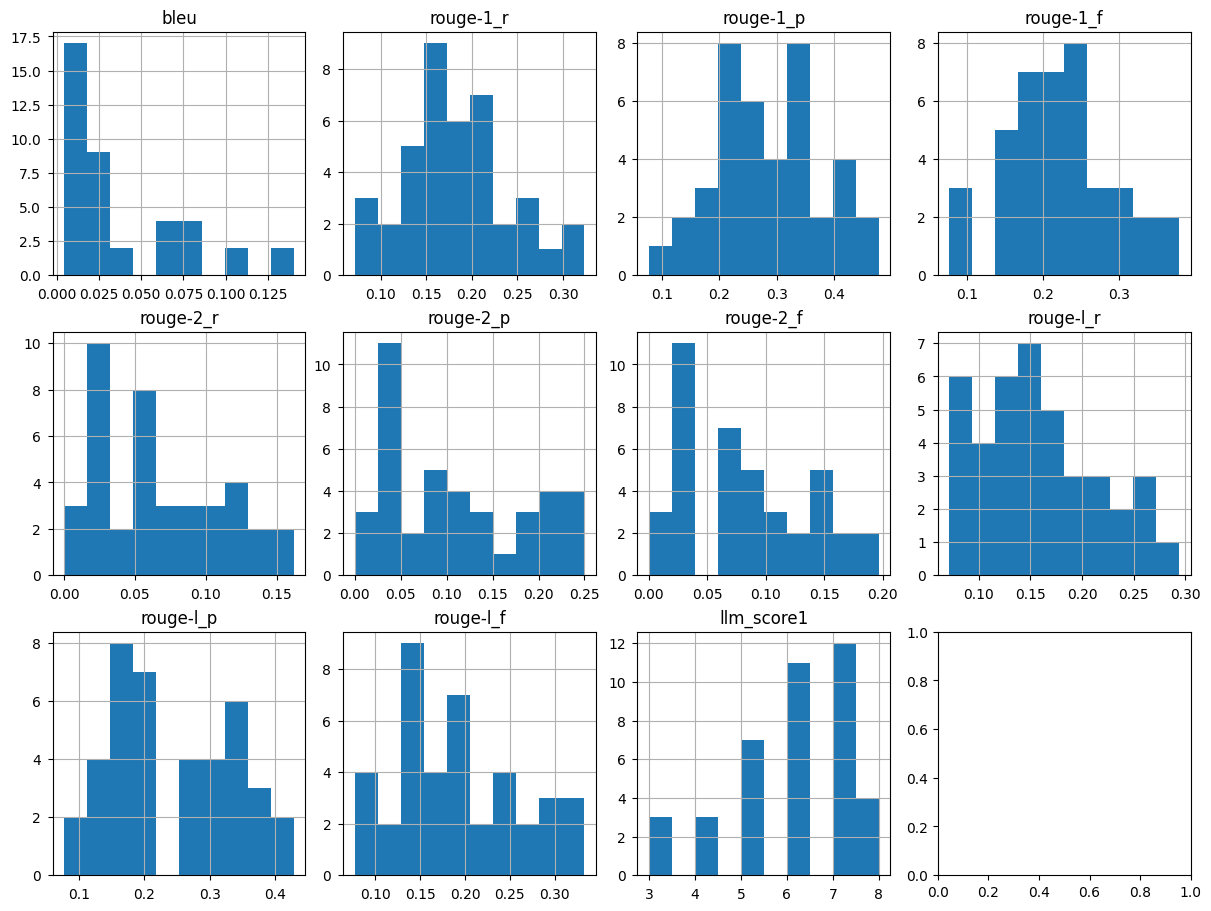

In [ ]:
import matplotlib.pyplot as plt

cols = ['bleu'] + df.columns[df.columns.str.contains('rouge')].tolist() + ['llm_score1']

fig, axes = plt.subplots(3, 4, figsize=(12, 9), constrained_layout=True)

for i, ax in enumerate(axes.flat):
    if i < len(cols):
        df[cols[i]].hist(ax=ax)
        ax.set_title(cols[i], fontsize=12)
        ax.tick_params(axis='both', which='major', pad=5)        
    

plt.show()

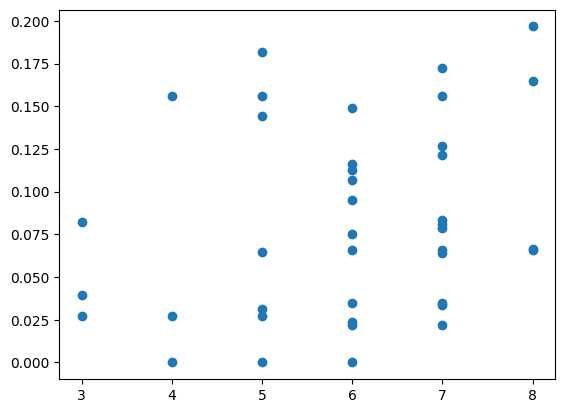

In [ ]:
plt.scatter(df['llm_score1'], df['rouge-2_f'])  # мда